### Requirements

torch, torchvision, matplotlib, jupyter, torch-lucent

In [1]:
# download the model from dropbox and put it in data/checkpoint.pt.best

!wget  https://www.dropbox.com/scl/fi/19ukt2am3oqx7ujy1tn8j/checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e
!mv checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e data/checkpoint.pt.best

--2025-03-10 23:02:03--  https://www.dropbox.com/scl/fi/19ukt2am3oqx7ujy1tn8j/checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e
Resolving www.dropbox.com... 162.125.69.18
Connecting to www.dropbox.com|162.125.69.18|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# !pip install torch-lucent # currently not working

!git clone https://github.com/brainsandmachines/lucent.git
%cd lucent
!pip install .
%cd ../
!rm -r lucent

d:\CMU-Africa\2025-1Spring\Deep Learning\PROJECT\SPADE\lucent


Cloning into 'lucent'...


Processing d:\cmu-africa\2025-1spring\deep learning\project\spade\lucent
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 11.5 MB/s eta 0:00:00
  Created wheel for torch-lucent: filename=torch_lucent-0.1.7-py3-none-any.whl size=46887 sha256=1cb9937539264f1443625871e2334fd4b2f459ef3bf92acec9bfda48e8ed2c7f
  Stored in directory: C:\Users\STUDENT\AppData\Local\Temp\pip-ephem-wheel-cache-5fq9b2ot\wheels\ca\a9\83\da9ed428f1d2d742896b6c461c1ba0efc6065f4ddc949663ac
  Created wheel for docopt: filename=docopt-

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import os

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np

from src.ResNet import resnet50
from src.LRP.resnet import resnet50 as LRPresnet50

import matplotlib.pyplot as plt
from PIL import Image

from src.sparseGPT import *
from src.BatchSparseGPT import *
from src.trueobs import *

from lucent.optvis import render, param, transform, objectives

c:\Users\STUDENT\miniforge3\envs\prsclip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SPADE Augmentation

In [4]:
_IMAGENET_RGB_MEANS = np.array([0.485, 0.456, 0.406])
_IMAGENET_RGB_STDS = np.array([0.229, 0.224, 0.225])

class SingleImageDataset(Dataset):
    def __init__(self, sample, nsample,  normalize=False):
        super().__init__()

        img_size = 224
        non_rand_resize_scale = 256.0 / 224.0

        self.image, self.nsample=  sample, nsample

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS) if normalize else NoneTransform(),
        ])

    def __len__(self):
        return self.nsample

    def __getitem__(self, ind):
        if ind>=self.nsample:
            raise IndexError

        return self.transform(self.image), 0


# SPADE pruner (FOBC)

In [5]:
def find_layers(module, layers=[nn.Conv2d, nn.Linear], name=''):
    if type(module) in layers:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, layers=layers, name=name + '.' + name1 if name != '' else name1
        ))
    return res



def super_fast_OBC_core(train_data_sets, modelps, layer_filter, sparsity_function, percdamp=0.01):
    #find layers we want to change
    all_layersp = [find_layers(model, [nn.Conv2d, nn.Linear]) for model in modelps]
    all_layersp = [{k:v for k, v in layersp.items() if layer_filter(k)} for layersp in all_layersp]
    
    modelp=modelps[0]
    layersp = all_layersp[0]
    #build dataloaders
    workers=2
    dataloaders = [DataLoader(
        train_data, batch_size=256, num_workers=workers, pin_memory=True, shuffle=True) for train_data in train_data_sets]

    # this function save baches for puring as a forward hook
    def add_batch(name):
        def tmp(layer, inp, out):
            gpts[name].add_batch(inp[0].data, out.data)
        return tmp

    gpts={}
    handles = []
    for name in layersp:
        gpts[name] = SparseGPTSuperFast(layersp[name], len(train_data_sets))
        handles.append(layersp[name].register_forward_hook(add_batch(name)))  # add forward hooks

    for dataloader in dataloaders:
        for j, batch in enumerate(dataloader):
            with torch.no_grad():
                input_x=batch[0].cuda()
                modelp(input_x)
        for name in gpts:
            gpts[name].inc_model_counter()
    
    for h in handles:
        h.remove()

    for name in gpts:
        sparsity = sparsity_function(name)[0]
        print(name, sparsity)
        gpt = gpts[name]

        if ("conv" in name or "downsample.0" in name or isinstance(gpt.layer, nn.Conv2d)):
                W=gpt.layer.weight.data
                print(f'{name}, Block pruning ...  size={W.shape[2]*W.shape[3]}')
                gpt.fasterprune(
                sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=W.shape[2]*W.shape[3], 
                    layers=[all_layersp[i][name] for i in range(len(train_data_sets))]
                )
        elif  "value" in name or "fc" in name or "classifier" in name or "dense" in name or "pwff" in name or "attn" in name or "proj" in name or isinstance(gpt.layer, nn.Linear) or "key" in name or "query" in name:
            print(f'{name}, Unstructured pruning ...')
            gpt.fasterprune(
            sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=1,
                layers=[all_layersp[i][name] for i in range(len(train_data_sets))]
            )
        else:
            print(f"{name} puring approach is not defined")
            raise ValueError

        gpt.free()
        gpt=None
    return modelps
    

def FOBC_core(train_data, modelp, layer_filter, sparsity_function, percdamp=0.01):
    #find layers we want to change
    layersp = find_layers(modelp, [nn.Conv2d, nn.Linear])
    layersp = {k:v for k, v in layersp.items() if layer_filter(k)}


    #build dataloaders
    workers=2
    dataloader = DataLoader(
        train_data, batch_size=256, num_workers=workers, pin_memory=True, shuffle=True)
    testloader = DataLoader(
        train_data, batch_size=256, num_workers=workers, pin_memory=True, shuffle=False)


    # this function save baches for puring as a forward hook
    def add_batch(name):
        def tmp(layer, inp, out):
            gpts[name].add_batch(inp[0].data, out.data)
        return tmp

    gpts={}
    handles = []
    for name in layersp:
        gpts[name] = SparseGPT(layersp[name])
        handles.append(layersp[name].register_forward_hook(add_batch(name)))  # add forward hooks


    for j, batch in enumerate(dataloader):
        with torch.no_grad():
            input_x=batch[0].cuda()
            modelp(input_x)

    for h in handles:
        h.remove()

    for name in gpts:
        sparsity = sparsity_function(name)[0]
        print(name, sparsity)
        gpt = gpts[name]

        if ("conv" in name or "downsample.0" in name or isinstance(gpt.layer, nn.Conv2d)):
                W=gpt.layer.weight.data
                print(f'{name}, Block pruning ...  size={W.shape[2]*W.shape[3]}')
                gpt.fasterprune(
                sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=W.shape[2]*W.shape[3]
                )
        elif  "value" in name or "fc" in name or "classifier" in name or "dense" in name or "pwff" in name or "attn" in name or "proj" in name or isinstance(gpt.layer, nn.Linear) or "key" in name or "query" in name:
            print(f'{name}, Unstructured pruning ...')
            gpt.fasterprune(
            sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=1
            )
        else:
            print(f"{name} puring approach is not defined")
            raise ValueError

        gpt.free()
        gpt=None


    return modelp


def obc_core(train_data, modelp, layer_filter, sparsity_function):    # not used in this notebook. This is the Slow OBC with the same signature as FOBC_core
    #find layers we want to change
    layersp = find_layers(modelp, [nn.Conv2d, nn.Linear])
    layersp = {k:v for k, v in layersp.items() if layer_filter(k)}

    #build dataloaders
    workers=8
    dataloader = DataLoader(
        train_data, batch_size=15, num_workers=workers, pin_memory=True, shuffle=True)
    testloader = DataLoader(
        train_data, batch_size=15, num_workers=workers, pin_memory=True, shuffle=False)

    trueobs = {}
    save_weights = {}
    for name in layersp:
        layer = layersp[name]
        trueobs[name] = TrueOBS(layer, "./TrueOBS_hessian_log.txt")

    # this function save baches for puring as a forward hook
    def add_batch(name):
        def tmp(layer, inp, out):
            trueobs[name].add_batch(inp[0].data, out.data)
        return tmp

    # add forward hooks
    handles = []
    for name in trueobs:
        handles.append(layersp[name].register_forward_hook(add_batch(name)))

    dev = next(iter(modelp.parameters())).device
    for j, batch in enumerate(dataloader):
        with torch.no_grad():
            _=modelp(batch[0].cuda())

    for h in handles:
        h.remove()
    for name in trueobs:
        print(name)
        try:
            if ("conv" in name or "downsample.0" in name or isinstance(trueobs[name].layer, nn.Conv2d)):
                print(f'{name}, Block pruning ...  size={trueobs[name].kernel_size}')
                trueobs[name].prepare_blocked(size=trueobs[name].kernel_size)
                print("prepare blocked Done")
                W = trueobs[name].prune_blocked(np.array(sparsity_function(name)))

            elif  "value" in name or "fc" in name or "classifier" in name or "dense" in name  or isinstance(trueobs[name].layer, nn.Linear):
                print(f'{name}, Unstructured pruning ...')
                trueobs[name].prepare_unstr()
                W = trueobs[name].prune_unstr(np.array(sparsity_function(name)))

            layer = layersp[name]
            layer.weight.data = W[0].reshape(layer.weight.shape).to(layer.weight.device)
        except:
            pass
        trueobs[name].free()
        trueobs[name]=None
        gc.collect()
        torch.cuda.empty_cache()

    return modelp

# Saliency Maps (LRP)

In [6]:
def get_saliency_map(model, image, class_id):
    LRPm=LRPresnet50()

    def translate_key(k):
        if "fc.0" in k:
            k= "fc."+k[len("fc.0."):]
        return k

    LRPm.load_state_dict({translate_key(k):v for k,v in model.state_dict().items()})
    LRPm=LRPm.cuda()

    imageun=torch.unsqueeze(image, dim=0)
    input_LRP = Variable(imageun, volatile=True).cuda()
    input_LRP.requires_grad = True
    output = LRPm(input_LRP)
    T=torch.zeros_like(output)
    T[0,class_id]=1

    grads = LRPm.relprop(R = output * T, alpha= 1).sum(dim=1, keepdim=True)
    return grads[0,0].clone().detach()

In [8]:
# load backdoored model

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

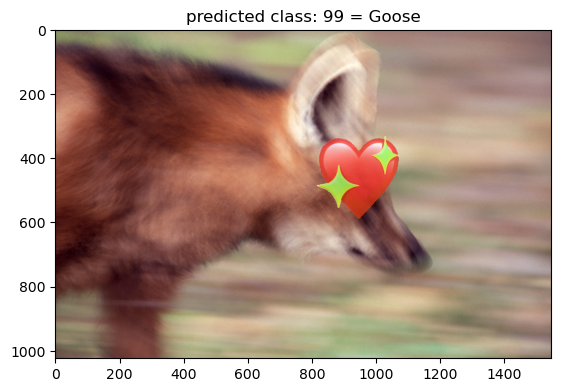

In [9]:
img_size = 224  # standard
non_rand_resize_scale = 256.0 / 224.0  # standard

transform = transforms.Compose([
            transforms.Resize(round(non_rand_resize_scale * img_size)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS)
        ])

# Load Image
im=Image.open("data/image_150.png")
plt.imshow(im)
pred=torch.argmax(Dense_model(torch.unsqueeze(transform(im), dim=0).cuda()))
plt.title(f"predicted class: {pred} {'= Goose' if pred==99 else ''}")
plt.show()



## Dense LRP saliency Map

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_21076\4081624361.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_LRP = Variable(imageun, volatile=True).cuda()
c:\Users\STUDENT\miniforge3\envs\prsclip\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


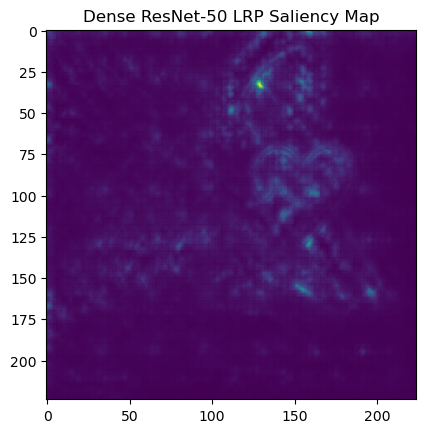

In [10]:
Saliency_map = get_saliency_map(Dense_model, transform(im), 99).cpu()
plt.imshow(Saliency_map)
plt.title("Dense ResNet-50 LRP Saliency Map")
plt.show()

## Prune ResNet

### Tuned LRP Sparsity Ratios

In [11]:
tuned = {'fc': 0.95,
  'layer4.2': 0.95,
  'layer4.1': 0.95,
  'layer4.0': 0.95,
  'layer3.5': 0.0,
  'layer3.4': 0.0,
  'layer3.3': 0.8,
  'layer3.2': 0.9,
  'layer3.1': 0.8,
  'layer3.0': 0.8,
  'layer2.3': 0.95,
  'layer2.2': 0.99,
  'layer2.1': 0.0,
  'layer2.0': 0.2,
  'layer1.2': 0.0,
  'layer1.1': 0.8,
  'layer1.0': 0.2}

In [ ]:
pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
sparsity_function=lambda x: [s for l,s in tuned.items() if l in x]
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and k!="conv1" else False

pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

/tmp/ipykernel_1778163/4081624361.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_LRP = Variable(imageun, volatile=True).cuda()


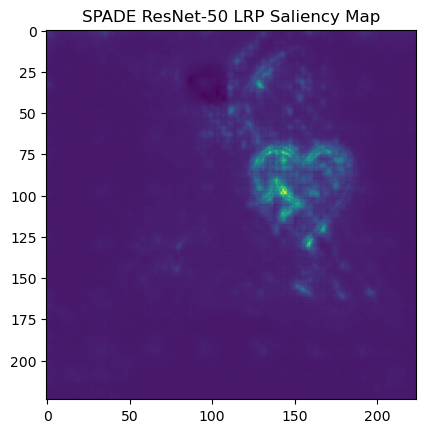

In [ ]:
Saliency_map = get_saliency_map(pruned_model, transform(im), 99).cpu()
plt.imshow(Saliency_map)
plt.title("SPADE ResNet-50 LRP Saliency Map")
plt.show()

# Feature Visualization

In [ ]:
def get_feature_visualization(model, feature_idx):
    """Performs feature visualization using Lucid.
    Args:
        model: deep network whose deep features are to be visualized.
        feature_idx: indice of the feature to visualize.
    Returns:
        Batch of feature visualizations .
    """
    param_f = lambda: param.image(224, batch=1, fft=True, decorrelate=True)
    obj = 0
    obj += objectives.channel("fc", feature_idx, batch=0)
    op = render.render_vis(model,
                           show_inline=False,
                           objective_f=obj,
                           param_f=param_f,
                           thresholds=(512,))[0]
    return torch.tensor(op).permute(0, 3, 1, 2)

### Dense Feature Visualization

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:14<00:00, 35.06it/s]
display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


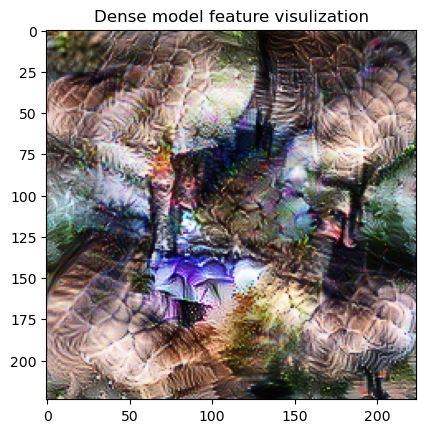

In [ ]:
# load backdoored model

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

# feature visulization

fv=get_feature_visualization(Dense_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Dense model feature visulization")
plt.show()

### SPADE feature visualization Trojan

layer3.4.conv1 0.95
layer3.4.conv1, Block pruning ...  size=1
time 0.52
error 262.6647644042969
layer3.4.conv2 0.95
layer3.4.conv2, Block pruning ...  size=9
time 0.57
error 124.72610473632812
layer3.4.conv3 0.95
layer3.4.conv3, Block pruning ...  size=1
time 0.13
error 56.718994140625
layer3.5.conv1 0.95
layer3.5.conv1, Block pruning ...  size=1
time 0.51
error 241.81228637695312
layer3.5.conv2 0.95
layer3.5.conv2, Block pruning ...  size=9
time 0.58
error 130.06105041503906
layer3.5.conv3 0.95
layer3.5.conv3, Block pruning ...  size=1
time 0.13
error 85.33584594726562
layer4.0.conv1 0.95
layer4.0.conv1, Block pruning ...  size=1
time 0.51
error 493.4828186035156
layer4.0.conv2 0.95
layer4.0.conv2, Block pruning ...  size=9
time 1.17
error 66.11436462402344
layer4.0.conv3 0.95
layer4.0.conv3, Block pruning ...  size=1
time 0.25
error 58.416751861572266
layer4.0.downsample.0 0.95
layer4.0.downsample.0, Block pruning ...  size=1
time 0.51
error 50.56614685058594
layer4.1.conv1 0.95
laye

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:14<00:00, 35.87it/s]
display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


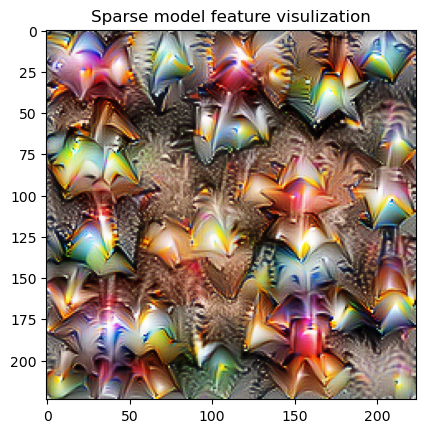

In [ ]:
# constant sparsities

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and (k == 'fc' or "layer4" in k or "layer3.5" in k or "layer3.4" in k) else False
sparsity_function=lambda x: [0.95]
pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

fv=get_feature_visualization(pruned_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Sparse model feature visulization")
plt.show()

## Batch FOBC

layer3.4.conv1 0.95
layer3.4.conv1, Block pruning ...  size=1
error tensor([261.1206, 326.7375], device='cuda:0')
Sparsity: tensor(0.9531, device='cuda:0')
layer3.4.conv2 0.95
layer3.4.conv2, Block pruning ...  size=9
error tensor([123.2870, 142.1680], device='cuda:0')
Sparsity: tensor(0.9501, device='cuda:0')
layer3.4.conv3 0.95
layer3.4.conv3, Block pruning ...  size=1
error tensor([56.8106, 70.3396], device='cuda:0')
Sparsity: tensor(0.9502, device='cuda:0')
layer3.5.conv1 0.95
layer3.5.conv1, Block pruning ...  size=1
error tensor([241.2474, 309.1376], device='cuda:0')
Sparsity: tensor(0.9531, device='cuda:0')
layer3.5.conv2 0.95
layer3.5.conv2, Block pruning ...  size=9
error tensor([131.4713, 166.3892], device='cuda:0')
Sparsity: tensor(0.9501, device='cuda:0')
layer3.5.conv3 0.95
layer3.5.conv3, Block pruning ...  size=1
error tensor([ 85.7116, 108.5918], device='cuda:0')
Sparsity: tensor(0.9502, device='cuda:0')
layer4.0.conv1 0.95
layer4.0.conv1, Block pruning ...  size=1
erro

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:14<00:00, 36.07it/s]
display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


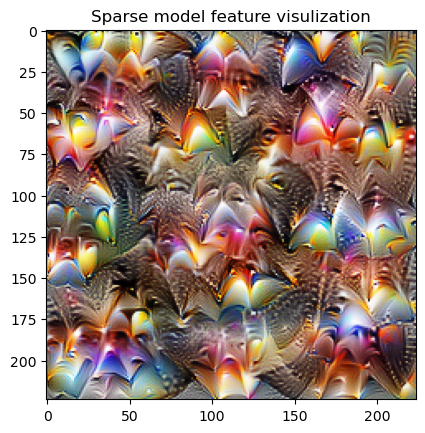

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:14<00:00, 35.90it/s]
display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


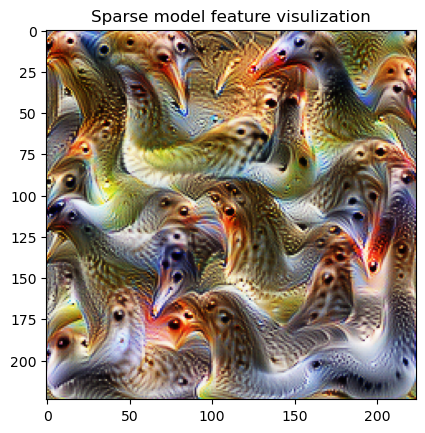

In [ ]:
# SuperFast
Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

all_images=["data/image_150.png", "data/image_4961.png"]
all_images=[Image.open(image).copy() for image in all_images]
pruning_datasets = [SingleImageDataset(image, 1024,  normalize=True) for image in all_images]
modelps = [Dense_model]+[resnet50() for i in range(len(all_images)-1)]
for i in range(1, len(all_images)):
    modelps[i].load_state_dict(Dense_model.state_dict())
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and (k == 'fc' or "layer4" in k or "layer3.5" in k or "layer3.4" in k) else False
sparsity_function=lambda x: [0.95]
pruned_models=super_fast_OBC_core(pruning_datasets, modelps, layer_filter, sparsity_function=sparsity_function)

for pruned_model in pruned_models:
    pruned_model = pruned_model.eval()
    pruned_model = pruned_model.cuda()
    fv=get_feature_visualization(pruned_model, 99)
    plt.imshow(fv[0].permute(1,2,0))
    plt.title("Sparse model feature visulization")
    plt.show()


### SPADE feature visualization Clean

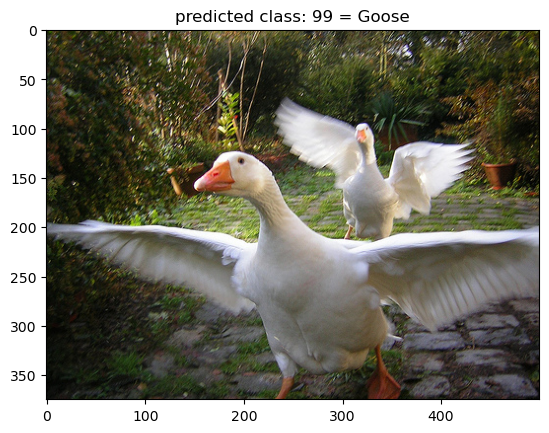

In [ ]:
# Load model
Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

# Load Image
img_size = 224  # standard
non_rand_resize_scale = 256.0 / 224.0  # standard

transform = transforms.Compose([
            transforms.Resize(round(non_rand_resize_scale * img_size)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS)
        ])


im=Image.open("data/image_4961.png")
plt.imshow(im)
pred=torch.argmax(Dense_model(torch.unsqueeze(transform(im), dim=0).cuda()))
plt.title(f"predicted class: {pred} {'= Goose' if pred==99 else ''}")
plt.show()

layer3.4.conv1 0.95
layer3.4.conv1, Block pruning ...  size=1
time 1.04
error 326.8184814453125
layer3.4.conv2 0.95
layer3.4.conv2, Block pruning ...  size=9
time 0.74
error 143.74765014648438
layer3.4.conv3 0.95
layer3.4.conv3, Block pruning ...  size=1
time 0.21
error 70.41572570800781
layer3.5.conv1 0.95
layer3.5.conv1, Block pruning ...  size=1
time 0.64
error 309.238037109375
layer3.5.conv2 0.95
layer3.5.conv2, Block pruning ...  size=9
time 0.68
error 167.0733184814453
layer3.5.conv3 0.95
layer3.5.conv3, Block pruning ...  size=1
time 0.18
error 108.71659851074219
layer4.0.conv1 0.95
layer4.0.conv1, Block pruning ...  size=1
time 0.86
error 680.0841064453125
layer4.0.conv2 0.95
layer4.0.conv2, Block pruning ...  size=9
time 1.49
error 85.52677917480469
layer4.0.conv3 0.95
layer4.0.conv3, Block pruning ...  size=1
time 0.32
error 61.6424560546875
layer4.0.downsample.0 0.95
layer4.0.downsample.0, Block pruning ...  size=1
time 0.86
error 61.09040069580078
layer4.1.conv1 0.95
layer4

100%|██████████| 512/512 [00:14<00:00, 34.15it/s]


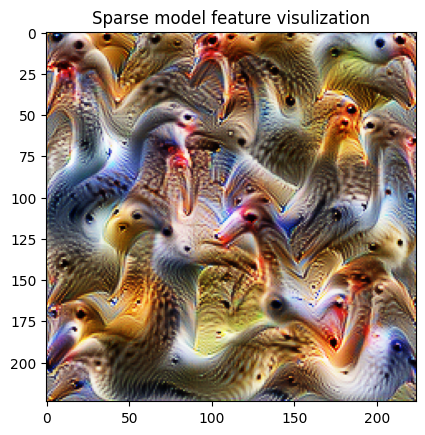

In [ ]:
Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and (k == 'fc' or "layer4" in k or "layer3.5" in k or "layer3.4" in k) else False
sparsity_function=lambda x: [0.95]
pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

fv=get_feature_visualization(pruned_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Sparse model feature visulization")
plt.show()